# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import datetime as dt

import re

import numpy as np

import itertools

from scipy.stats import norm

from itertools import combinations

from scipy.stats import ttest_ind

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

In [2]:
df = pd.read_csv('main_task.csv')

In [3]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

In [4]:
def split_reviews(column):
    """Функция для извлечения текста отзыва из столбца Reviews"""
    reviews_and_dates = column
    reviews_and_dates = reviews_and_dates.split("], [")
    reviews = reviews_and_dates[0]
    review_dates = reviews_and_dates[1]

    reviews = re.sub("\[", "", reviews)
    reviews = re.sub("\]", "", reviews)
    reviews = re.sub("\'", "", reviews)
    reviews = re.sub(",", "", reviews)
    reviews = reviews.lower()
    return reviews


def split_review_dates(column):
    """Функция для извлечения даты отзыва из столбца Reviews"""
    reviews_and_dates = column
    reviews_and_dates = reviews_and_dates.split("], [")
    reviews = reviews_and_dates[0]
    review_dates = reviews_and_dates[1]

    review_dates = re.sub("\[", "", review_dates)
    review_dates = re.sub("\]", "", review_dates)
    review_dates = re.sub("\'", "", review_dates)
    review_dates = review_dates.split(",")
    return review_dates

def cuisine_style_to_list(column):
    """Функция для переформатирования столбца Cuisine Style в список"""
    cuisines = re.sub("\[", "", column)
    cuisines = re.sub("\]", "", cuisines)
    cuisines = re.sub("\'", "", cuisines)
    cuisines = cuisines.split(",")
    return cuisines

## Общие изменения

In [5]:
# убираем дубликаты
df = df.drop_duplicates(subset='ID_TA').reset_index()

In [6]:
# заполняем отсутствующие значения в Number of Reviews нулями
df['Number of Reviews'] = df['Number of Reviews'].fillna(0)

In [7]:
# Заполняем пропуски в Price Range наиболее частым значением '$$ - $$$' и переформатируем значения в цифры
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')
df['Price Range'] = df['Price Range'].apply(lambda x: 0 if x == '$' 
                                            else (0.5 if x == '$$ - $$$' else 1))
df['Price Range'].value_counts()

0.5    32281
0.0     6276
1.0     1423
Name: Price Range, dtype: int64

## Преобразование дат отзывов

In [8]:
# Выделяем даты отзывов в отдельную колонку
df['Review dates'] = df['Reviews'].apply(split_review_dates)
df['Review dates']

0        [12/31/2017,  11/20/2017]
1        [07/06/2017,  06/19/2016]
2        [01/08/2018,  01/06/2018]
3                               []
4        [11/18/2017,  02/19/2017]
                   ...            
39975    [12/16/2017,  11/12/2017]
39976    [12/21/2017,  12/12/2017]
39977    [11/03/2016,  04/12/2008]
39978    [07/11/2017,  06/18/2017]
39979    [01/31/2016,  07/04/2012]
Name: Review dates, Length: 39980, dtype: object

In [9]:
# Добавляем столбец с датой последнего отзыва
df['Last review date'] = df['Review dates'].apply(lambda x: pd.to_datetime(x[0]))
df['Last review date']

0       2017-12-31
1       2017-07-06
2       2018-01-08
3              NaT
4       2017-11-18
           ...    
39975   2017-12-16
39976   2017-12-21
39977   2016-11-03
39978   2017-07-11
39979   2016-01-31
Name: Last review date, Length: 39980, dtype: datetime64[ns]

In [10]:
# Добавляем столбец с датой первого отзыва
df['First review date'] = df['Review dates'].apply(lambda x: pd.to_datetime(x[-1]))
df['First review date']

0       2017-11-20
1       2016-06-19
2       2018-01-06
3              NaT
4       2017-02-19
           ...    
39975   2017-11-12
39976   2017-12-12
39977   2008-04-12
39978   2017-06-18
39979   2012-07-04
Name: First review date, Length: 39980, dtype: datetime64[ns]

In [11]:
# Добавляем столбец с разницей дат отзывов
df['Review date difference'] = df['Last review date'] - df['First review date']
df['Review date difference'] = df['Review date difference'].fillna(pd.Timedelta('0 days'))
df['Review date difference'] = df['Review date difference'].apply(lambda x: x * -1 if x < dt.timedelta(days=0) else x)
df['Review date difference'] = df['Review date difference'].dt.days.astype('int64')
df['Review date difference']

0          41
1         382
2           2
3           0
4         272
         ... 
39975      34
39976       9
39977    3127
39978      23
39979    1306
Name: Review date difference, Length: 39980, dtype: int64

## Анализ слов в отзывах

In [12]:
# Трансформируем отзывы в текст
df['Reviews'] = df['Reviews'].apply(split_reviews)
df['Reviews']

0        good food at your doorstep a good hotel restau...
1                   unique cuisine delicious nepalese food
2                    catch up with friends not exceptional
3                                                         
4        best place to try a bavarian food nice buildin...
                               ...                        
39975    the real italian experience! wonderful food wo...
39976    parisian atmosphere bit pricey but interesting...
39977    good by swedish standards a hidden jewel in th...
39978    underground restaurant oldest restaurant in wa...
39979                             average nice an informal
Name: Reviews, Length: 39980, dtype: object

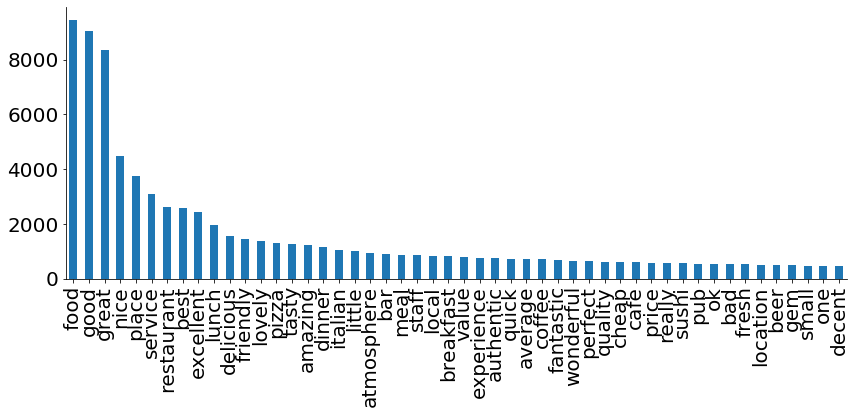

In [13]:
# Посмотрим, какие слова самые популярные в отзывах
# Делаем список шумовых слов
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", 
             "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 
             'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 
             'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 
             'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 
             'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 
             'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 
             'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 
             'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 
             'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 
             'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', 
             "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', 
             "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', 
             "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 
             'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 
             'wouldn', "wouldn't"]

# Делаем список слов в отзывах
words_in_reviews = pd.Series(
    list(itertools.chain(*df['Reviews'].str.split(" ").tolist())))


# считаем количество слов в списке за исключеним шумовых
top_words = words_in_reviews.value_counts()
top_words = top_words.iloc[
    np.argwhere(top_words.index.map(lambda t: str(t).lower() not in stopwords).values).flatten()
]

# Исключаем из списка знаки препинания и выводим топ-50
top_words = top_words.drop(['-', '&', '!', '']).head(50)

# Строим диаграмму
top_words.head(50).plot.bar(figsize=(14, 5), fontsize=20)
sns.despine()

In [14]:
# Трансформируем топ 50 самых популярных слов в список
top_words = top_words.index.values.tolist()

In [15]:
# Убираем все слова из отзывов, кроме тех, что в списке
df['Reviews'] = df['Reviews'].apply(lambda x: [item for item in x.split() if item in top_words])
df['Reviews']

0                           [good, food, good, restaurant]
1                                        [delicious, food]
2                                                       []
3                                                       []
4                                [best, place, food, nice]
                               ...                        
39975    [italian, wonderful, food, wonderful, experience]
39976                                         [atmosphere]
39977                                               [good]
39978                             [restaurant, restaurant]
39979                                      [average, nice]
Name: Reviews, Length: 39980, dtype: object

In [16]:
# Делаем из топ 50 слов Dummy переменные и помещаем в отдельную таблицу

mlb = MultiLabelBinarizer()
top_words_table = pd.DataFrame(mlb.fit_transform(df['Reviews']),
                       columns=mlb.classes_, index=df.index)
top_words_table

,amazing,atmosphere,authentic,average,bad,bar,beer,best,breakfast,cafe,...,quick,really,restaurant,service,small,staff,sushi,tasty,value,wonderful
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
39976,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39978,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Преобразование типов кухонь 

In [17]:
# Переформатируем значения столбца Cuisine Style в список
df['Cuisine Style'] = df['Cuisine Style'].fillna('Local')
df['Cuisine Style'] = df['Cuisine Style'].apply(cuisine_style_to_list)
df['Cuisine Style']

0                      [European,  French,  International]
1                                                  [Local]
2        [Japanese,  Sushi,  Asian,  Grill,  Vegetarian...
3                                                  [Local]
4        [German,  Central European,  Vegetarian Friendly]
                               ...                        
39975    [Italian,  Vegetarian Friendly,  Vegan Options...
39976    [French,  American,  Bar,  European,  Vegetari...
39977                                   [Japanese,  Sushi]
39978    [Polish,  European,  Eastern European,  Centra...
39979                                            [Spanish]
Name: Cuisine Style, Length: 39980, dtype: object

In [18]:
# Создадим столбец с количеством кухонь в ресторане
df['Cuisines quantity'] = df['Cuisine Style'].apply(lambda x: len(x))
df['Cuisines quantity']

0        3
1        1
2        7
3        1
4        3
        ..
39975    4
39976    5
39977    2
39978    5
39979    1
Name: Cuisines quantity, Length: 39980, dtype: int64

In [19]:
# Переводим кухни в Dummy переменные и помещаем в отдельную таблицу
cuisines_table = pd.DataFrame(mlb.fit_transform(df['Cuisine Style']),
                       columns=mlb.classes_, index=df.index)
cuisines_table

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Thai,Tibetan,Turkish,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Wine Bar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39976,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Обогащаем данные по городам

In [20]:
# Посмотрим, какие города в нашем датасете
df['City'].value_counts()

London        5757
Paris         4897
Madrid        3088
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

In [21]:
# Соберем информацию об общем количестве ресторанов по городам в справочник (источник - tripadvisor)
restaurants_in_city = {
'London': 19449,
'Paris': 16726,
'Madrid': 10945,
'Barcelona': 9339,
'Berlin': 6496,
'Milan': 7106,
'Rome': 10551,
'Prague': 5275,
'Lisbon': 4722,
'Vienna': 4020,
'Amsterdam': 3871,
'Brussels': 3529,
'Hamburg': 3201,
'Munich': 3061,
'Lyon': 2715,
'Stockholm': 2894,
'Budapest': 2946,
'Warsaw': 3107,
'Dublin': 2291,
'Copenhagen': 2335,
'Athens': 2457,
'Edinburgh': 1860,
'Zurich': 1818,
'Oporto': 1914,
'Geneva': 1674,
'Krakow': 1678,
'Oslo': 1317,
'Helsinki': 1495,
'Bratislava': 1211,
'Luxembourg': 717,
'Ljubljana':578
}

In [22]:
# добавляем ресторанов по городам в датасет
df['Restaurants in city'] = df['City'].map(restaurants_in_city)
df['Restaurants in city']

0        16726
1         2894
2        19449
3         6496
4         3061
         ...  
39975     7106
39976    16726
39977     2894
39978     3107
39979     7106
Name: Restaurants in city, Length: 39980, dtype: int64

In [23]:
# добавляем отношение Ranking к количеству ресторанов в городе
df['Ranking percent'] = df['Ranking'] / df['Restaurants in city']
df['Ranking percent']

0        0.333014
1        0.531099
2        0.018150
3        0.532328
4        0.202875
           ...   
39975    0.070363
39976    0.379110
39977    0.570836
39978    0.206308
39979    0.679285
Name: Ranking percent, Length: 39980, dtype: float64

In [24]:
# Соберем информацию о населении городов в справочник (источник - wikipedia)
cities_population = {
'London': 8982000,
'Paris': 2148000,
'Madrid': 6642000,
'Barcelona': 1636762,
'Berlin': 3769000,
'Milan': 1378689,
'Rome': 2873000,
'Prague': 1309000,
'Lisbon': 505526,
'Vienna': 1888776,
'Amsterdam': 857713,
'Brussels': 174383,
'Hamburg': 1899000,
'Munich': 1472000,
'Lyon': 506615,
'Stockholm': 975904,
'Budapest': 1752286,
'Warsaw': 1790658,
'Dublin': 1173179,
'Copenhagen': 615993,
'Athens': 664046,
'Edinburgh': 488100,
'Zurich': 428737,
'Oporto': 237591,
'Geneva': 499480,
'Krakow': 769498,
'Oslo': 693491,
'Helsinki': 650058,
'Bratislava': 437725,
'Luxembourg': 626108,
'Ljubljana': 279631
}

In [25]:
# добавляем население в датасет
df['Population'] = df['City'].map(cities_population)
df['Population']

0        2148000
1         975904
2        8982000
3        3769000
4        1472000
          ...   
39975    1378689
39976    2148000
39977     975904
39978    1790658
39979    1378689
Name: Population, Length: 39980, dtype: int64

In [26]:
# добавляем столбец с отношением населения к кол-ву ресторанов
df['People per restaurant'] = df['Population'] / df['Restaurants in city']
df['People per restaurant']

0        128.422815
1        337.216310
2        461.823230
3        580.203202
4        480.888598
            ...    
39975    194.017591
39976    128.422815
39977    337.216310
39978    576.330222
39979    194.017591
Name: People per restaurant, Length: 39980, dtype: float64

In [27]:
# Проверяем датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39980 entries, 0 to 39979
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   index                   39980 non-null  int64         
 1   Restaurant_id           39980 non-null  object        
 2   City                    39980 non-null  object        
 3   Cuisine Style           39980 non-null  object        
 4   Ranking                 39980 non-null  float64       
 5   Rating                  39980 non-null  float64       
 6   Price Range             39980 non-null  float64       
 7   Number of Reviews       39980 non-null  float64       
 8   Reviews                 39980 non-null  object        
 9   URL_TA                  39980 non-null  object        
 10  ID_TA                   39980 non-null  object        
 11  Review dates            39980 non-null  object        
 12  Last review date        33515 non-null  dateti

In [28]:
# объединяем датасет с бинарными признаками
df = pd.concat([df, cuisines_table], axis=1)
df = pd.concat([df, top_words_table], axis=1)
df

In [29]:
df = df.drop(['index', 'Restaurant_id', 'City', 'Cuisine Style', 'Reviews', 'URL_TA',
              'Review dates', 'Last review date', 'First review date'], axis = 1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [30]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['ID_TA', 'Rating'], axis = 1)
y = df['Rating']

In [31]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [32]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [33]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [34]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [35]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21205502751375685
